In [1]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
import pickle, random, cv2
import matplotlib.pyplot as plt
from sklearn import svm as SVM
from sklearn.pipeline import Pipeline

# Constants

In [2]:
moods = ["anger","disgust","fear","happiness","sadness","surprise","neutral"]
mood_map = { moods[k]:k for k in range(len(moods)) } # mood : index
mood_map.update({ k:moods[k] for k in range(len(moods)) }) # index : mood
model_path = '../models/'

# Preparing the Data

### CK

In [6]:
data_path = '../dataset/ck/'
df_ck = pd.read_csv(data_path + 'vector_coords_norm.csv')
df_ck.head()

CPU times: total: 93.8 ms
Wall time: 115 ms


,filename,mood,vectors,coords
0,S010_004_00000019.png,anger,0.913848522815577 0.07291733991580246 0.825733...,0.0 0.20408163265306123 0.006622516556291391 0...
1,S011_004_00000021.png,anger,1.0 0.06939233223948903 0.9018695583426973 0.0...,0.0 0.14492753623188406 0.017964071856287425 0...
2,S014_003_00000030.png,anger,0.9226796499775556 0.07379180882521665 0.82635...,0.0 0.16428571428571428 0.0125 0.3142857142857...
3,S022_005_00000032.png,anger,1.0 0.06789987439004594 0.8821328104551961 0.0...,0.0 0.19834710743801653 0.023622047244094488 0...
4,S026_003_00000015.png,anger,1.0 0.08154931539664242 0.8700847531963809 0.0...,0.0 0.09345794392523364 0.024193548387096774 0...


In [7]:
neutral = random.sample(list(df_ck[df_ck['mood']=='neutral'].index), 100)
df_ck = df_ck[(df_ck['mood']!='neutral') | (df_ck.index.isin(neutral))] 

In [8]:
df_ck['mood'].value_counts()

neutral      100
surprise      83
happiness     69
disgust       59
anger         45
sadness       28
fear          25
Name: mood, dtype: int64

In [9]:
%%time
num_samples = df_ck.shape[0]

vectors, coords = [], []
for index, row in df_ck.iterrows():
    vectors.append([float(k) for k in row['vectors'].split(' ')])
    coords.append([float(k) for k in row['coords'].split(' ')])
vectors, coords = np.array(vectors), np.array(coords)

Vector = np.dstack((vectors, coords)).reshape(num_samples, -1) # shape=(samples, vectors+coords)
Label = np.array([mood_map[k] for k in df_ck.mood])
print(Vector.shape, Label.shape)

xtr_ck, xts_ck, ytr_ck, yts_ck = train_test_split(Vector, Label, test_size=0.20, random_state=42)

(409, 272) (409,)
CPU times: total: 172 ms
Wall time: 167 ms


### FER2013

In [3]:
data_path = '../dataset/fer2013/'
df_fer = pd.read_csv(data_path + 'vector_coords_norm.csv')
df_fer.head()

CPU times: total: 9.73 s
Wall time: 9.86 s


,emotion,pixels,Usage,vectors,coords
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training,1.0 0.0855595721559356 0.908951992362738 0.053...,0.0 0.05194805194805195 0.0 0.2207792207792207...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training,0.9097354562079145 0.03439099146890885 0.84523...,0.0 0.36363636363636365 0.024390243902439025 0...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training,0.8700982144280447 0.14542327599970098 0.76867...,0.07228915662650602 0.05 0.03614457831325301 0...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training,0.5993885222413324 0.083143088445855 0.5277248...,0.043010752688172046 0.2222222222222222 0.0537...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training,0.9739085450273313 0.06621872273103259 0.88574...,0.0 0.25 0.012345679012345678 0.39473684210526...


In [4]:
%%time
num_samples = df_fer.shape[0]

vectors, coords = [], []
for index, row in df_fer.iterrows():
    vectors.append([float(k) for k in row['vectors'].split(' ')])
    coords.append([float(k) for k in row['coords'].split(' ')])
vectors, coords = np.array(vectors), np.array(coords)

Vector = np.dstack((vectors, coords)).reshape(num_samples, -1) # shape=(samples, vectors+coords)
Label = df_fer.emotion
print(Vector.shape, Label.shape)

xtr_fer, xts_fer, ytr_fer, yts_fer = train_test_split(Vector, Label, test_size=0.20, random_state=42)

(35887, 272) (35887,)
CPU times: total: 11.1 s
Wall time: 11.2 s


# Training

In [14]:
%%time
params = {'C':[10e-3, 10e-2, 0.1, 1, 10, 10e2, 10e3, 10e5], 'kernel':('linear', 'poly', 'rbf', 'sigmoid'), 'decision_function_shape':('ovr', 'ovo')}
svm_ck = GridSearchCV(SVM.SVC(max_iter=100000, probability=True), params)

svm_ck.fit(xtr_ck, ytr_ck)
print(svm_ck.best_params_)

{'C': 1000.0, 'decision_function_shape': 'ovr', 'kernel': 'linear'}


In [25]:
%%time
svm_fer = SVM.SVC(C=10, max_iter=1e6, probability=True, kernel='linear', decision_function_shape='ovr')
svm_fer.fit(xtr_fer, ytr_fer)

CPU times: total: 15min 2s
Wall time: 15min 9s


SVC(C=10, kernel='linear', max_iter=1000000.0, probability=True)

In [ ]:
%%time
ada_ck = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1),
    n_estimators=500
)
model_ck.fit(xtr_ck, ytr_ck)

In [ ]:
%%time
ada_fer = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1),
    n_estimators=200
)
model_fer.fit(xtr_fer, ytr_fer)

# Evaluation

In [15]:
pred_ck = svm_ck.predict(xts_ck)
accuracy_score(yts_ck, pred_ck)

0.8292682926829268

In [16]:
pred_fer = svm_fer.predict(xts_fer)
accuracy_score(yts_fer, pred_fer)

0.47311228754527723

In [26]:
%%time
pred_fer = svm_fer.predict(xts_fer)
accuracy_score(yts_fer, pred_fer)

CPU times: total: 19 s
Wall time: 19 s


0.4848147116188353

In [ ]:
pred_ck = model_ck.predict(xts_ck)
accuracy_score(yts_ck, pred_ck)

In [ ]:
pred_fer = model_fer.predict(xts_fer)
accuracy_score(yts_fer, pred_fer)

# Save Model

In [ ]:
pickle.dump(model_ck, open(model_path + 'adaboost_ck', 'wb'))
pickle.dump(model_fer, open(model_path + 'adaboost_fer', 'wb'))

In [20]:
pickle.dump(svm_ck, open(model_path + 'svm_ck', 'wb'))

In [24]:
pickle.dump(svm_fer, open(model_path + 'svm_fer', 'wb'))

# Test Model

In [27]:
test_ck = pickle.load(open(model_path + 'svm_ck', 'rb'))
test_fer = pickle.load(open(model_path + 'svm_fer', 'rb'))

In [29]:
test_df = df_ck[df_ck['mood'].isin(['anger','sadness','disgust','fear'])]
display(test_df)

,filename,mood,vectors,coords
0,S010_004_00000019.png,anger,0.913848522815577 0.07291733991580246 0.825733...,0.0 0.20408163265306123 0.006622516556291391 0...
1,S011_004_00000021.png,anger,1.0 0.06939233223948903 0.9018695583426973 0.0...,0.0 0.14492753623188406 0.017964071856287425 0...
2,S014_003_00000030.png,anger,0.9226796499775556 0.07379180882521665 0.82635...,0.0 0.16428571428571428 0.0125 0.3142857142857...
3,S022_005_00000032.png,anger,1.0 0.06789987439004594 0.8821328104551961 0.0...,0.0 0.19834710743801653 0.023622047244094488 0...
4,S026_003_00000015.png,anger,1.0 0.08154931539664242 0.8700847531963809 0.0...,0.0 0.09345794392523364 0.024193548387096774 0...
...,...,...,...,...
221,S501_006_00000041.png,sadness,0.915103569654567 0.06163969137811817 0.837662...,0.0 0.24060150375939848 0.012578616352201259 0...
222,S503_006_00000020.png,sadness,0.8687444855261388 0.0644405292045783 0.812155...,0.0 0.20161290322580644 0.0 0.3387096774193548...
223,S504_006_00000018.png,sadness,0.9286296038660788 0.06297595450550239 0.86839...,0.0 0.2606060606060606 0.0 0.38181818181818183...
224,S505_006_00000019.png,sadness,0.9027713947052444 0.06226707633151013 0.81462...,0.0 0.2465753424657534 0.01764705882352941 0.3...


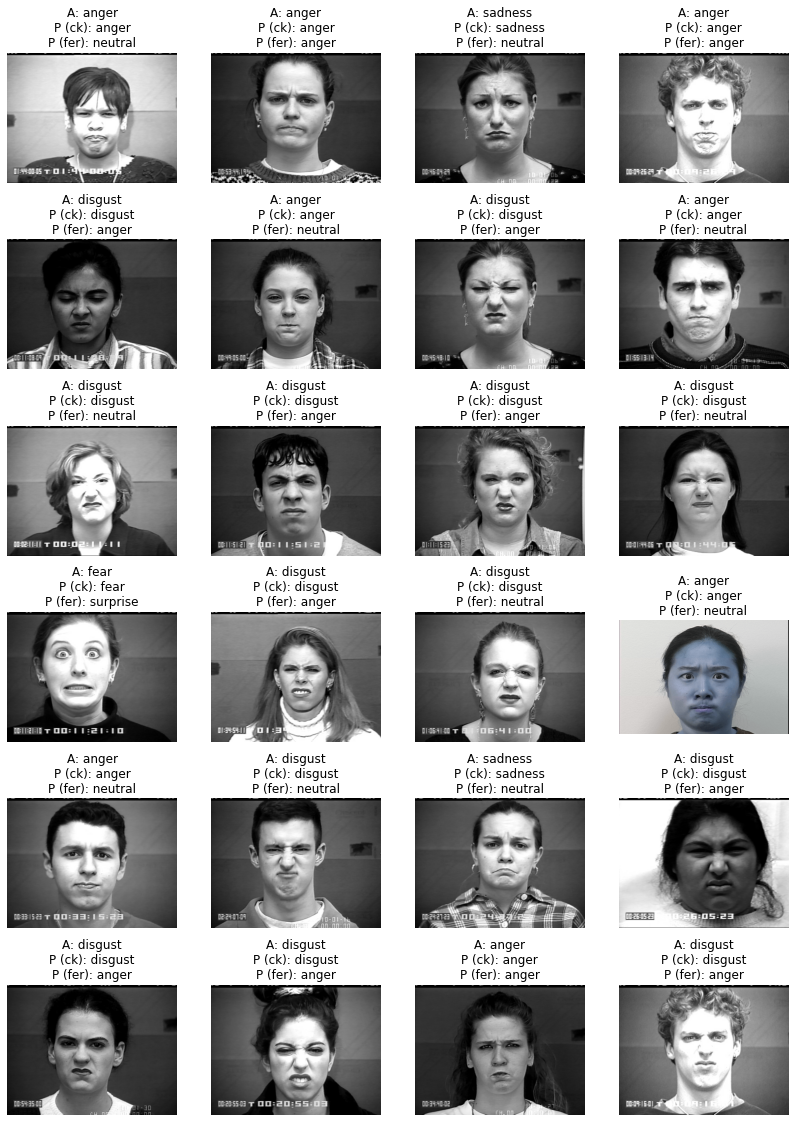

In [30]:
rand = random.sample(list(test_df.index), 24)
fig = plt.figure(figsize=(14, 20))
data_path = '../dataset/ck/'

for i in rand:
    filename, mood = test_df.loc[i,'filename'], test_df.loc[i,'mood']
    
    # input
    vectors = [float(k) for k in test_df.loc[i,'vectors'].split(' ')]
    coords = [float(k) for k in test_df.loc[i,'coords'].split(' ')]
    vectors, coords = np.array(vectors), np.array(coords)
    Vector = np.dstack((vectors, coords)).reshape(1, -1) # shape=(1, 272)

    # prediction
    pred_ck = mood_map[svm_ck.predict(Vector)[0]]
    pred_fer = mood_map[test_fer.predict(Vector)[0]]

    # plot
    fig.add_subplot(6, 4, rand.index(i)+1)    
    plt.title("A: %s\nP (ck): %s\nP (fer): %s" % (mood, pred_ck, pred_fer))
    plt.axis("off")
    img = cv2.imread('%s%s/%s' % (data_path, mood, filename))
    plt.imshow(img)

plt.show()